In [3]:
#Importing modules 
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from string import digits

#!pip install CurrencyConverter
#from currency_converter import CurrencyConverter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Read  in all 5 csv dataset, filtered out only Category=”Educational”, 
#combined the 5 subset dataset into one big dataset 

i_read=0

if i_read==1: 
    df0= pd.read_csv('Google-Playstore_0.csv',index_col=0)
    df1= pd.read_csv('Google-Playstore_1.csv',names=df0.columns,index_col=0)
    df2= pd.read_csv('Google-Playstore_2.csv',names=df0.columns,index_col=0)
    df3= pd.read_csv('Google-Playstore_3.csv',names=df0.columns,index_col=0)
    df4= pd.read_csv('Google-Playstore_4.csv',names=df0.columns,index_col=0)

    df0=df0.loc[df0['Category'].isin(['Educational','Education']),:]
    df1=df1.loc[df1['Category'].isin(['Educational','Education']),:]
    df2=df2.loc[df2['Category'].isin(['Educational','Education']),:]
    df3=df3.loc[df3['Category'].isin(['Educational','Education']),:]
    df4=df4.loc[df4['Category'].isin(['Educational','Education']),:]

    df=pd.concat([df0,df1,df2,df3,df4]) 
    df.drop('Category',axis=1,inplace=True)
    df.to_csv('Google_Playstore_Edapp.csv')

In [6]:
EdApp_df= pd.read_csv('Google_Playstore_Edapp.csv',parse_dates=[-1])

In [7]:
#Change names of columns and repalce spaces with "_"
EdApp_df.columns=EdApp_df.columns.str.replace(' ','_')
EdApp_df.rename(mapper={'Unnamed:_0':'App_Name'},axis=1, inplace=True)

In [8]:
#Convert  Released,  Last_Updated, Scrape_time to pd datetime objects 
EdApp_df.Released=pd.to_datetime(EdApp_df.Released)
EdApp_df.Last_Updated=pd.to_datetime(EdApp_df.Last_Updated)

In [9]:
EdApp_df_backup=EdApp_df
EdApp_df_backup.shape
EdApp_df_backup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262398 entries, 0 to 262397
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   App_Name           262398 non-null  object        
 1   App_Id             262398 non-null  object        
 2   Rating             260845 non-null  float64       
 3   Rating_Count       260845 non-null  float64       
 4   Installs           262396 non-null  object        
 5   Minimum_Installs   262396 non-null  float64       
 6   Maximum_Installs   262398 non-null  int64         
 7   Free               262398 non-null  bool          
 8   Price              262398 non-null  float64       
 9   Currency           262394 non-null  object        
 10  Size               262380 non-null  object        
 11  Minimum_Android    261759 non-null  object        
 12  Developer_Id       262396 non-null  object        
 13  Developer_Website  171159 non-null  object  

In [10]:
EdApp_df=EdApp_df_backup
EdApp_df.shape

(262398, 23)

# 1. Feature Engineering 

### Drop features and delete duplicate Apps

In [11]:
#drop duplicate Apps if any
EdApp_df.drop_duplicates(subset=['App_Name','Developer_Id', 'Developer_Email'],\
                         ignore_index=True,inplace=True)
print(EdApp_df.shape)

(261920, 23)


In [12]:
##Drop these columns: App ID, minimum and maximum installs, 
##developer ID, website and email, privacy policy link.
EdApp_df.drop(['App_Id','Minimum_Installs', 'Maximum_Installs','Developer_Website','Developer_Email','Developer_Id','Privacy_Policy','Scraped_Time'],\
              axis=1,inplace=True)

###  missing values

<Figure size 1000x600 with 0 Axes>

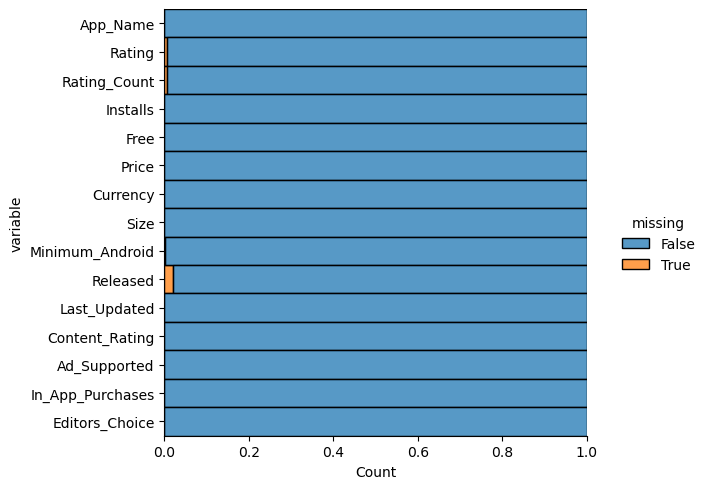

In [13]:
plt.figure(figsize=(10,6))
sns.displot(
    data=EdApp_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

In [14]:
print(EdApp_df.select_dtypes(include='object').nunique())
print(EdApp_df.select_dtypes(include='object').isna().sum())

App_Name           252184
Installs               18
Currency                5
Size                 1353
Minimum_Android        55
Content_Rating          6
dtype: int64
App_Name             0
Installs             2
Currency             4
Size                18
Minimum_Android    639
Content_Rating       0
dtype: int64


## Drop Apps with missing values in Installs, Currency,Size  

In [15]:
EdApp_df.dropna(subset=['Installs','Currency', 'Size'],inplace=True)

In [16]:
#print(EdApp_df.Installs.unique())
#print(EdApp_df.Installs.value_counts(dropna=False))

In [17]:
print(EdApp_df.select_dtypes(include='bool').nunique())
print(EdApp_df.select_dtypes(include='bool').isna().sum())

Free                2
Ad_Supported        2
In_App_Purchases    2
Editors_Choice      2
dtype: int64
Free                0
Ad_Supported        0
In_App_Purchases    0
Editors_Choice      0
dtype: int64


## Drop Apps with missing values in Rating, Rating_Count  

In [18]:
print(EdApp_df.select_dtypes(include='float64').nunique())
print(EdApp_df.select_dtypes(include='float64').isna().sum())

Rating            42
Rating_Count    6392
Price            344
dtype: int64
Rating          1530
Rating_Count    1530
Price              0
dtype: int64


In [19]:
##it is found that Apps with missing values in Rating is also missing in Rating_Counts
##do drop Apps with missing values in both

##EdApp_df[['Rating','Rating_Count']].isna().sum(axis=1).value_counts()

#  0    260368
#  2      1548
#  dtype: int64

EdApp_df.dropna(subset=['Rating','Rating_Count'],inplace=True)
print(EdApp_df.shape)

(260368, 15)


In [20]:
##it is found that Apps with Rating=0 is also having Rating_Count=0
##do drop Apps with 0 in both


#EdApp_df.loc[EdApp_df['Rating']==0, ['Rating','Rating_Count']].nunique()

#  Rating          1
#  Rating_Count    1
#  dtype: int64


EdApp_df=EdApp_df.loc[EdApp_df['Rating']>0,:]

print(EdApp_df.shape)    # (140461, 16)
print(EdApp_df.isna().sum())

##check to make sure that there is no zero value in neither Rating nor Rating_Count

print(EdApp_df['Rating'].min())
print(EdApp_df['Rating_Count'].min())


(140461, 15)
App_Name               0
Rating                 0
Rating_Count           0
Installs               0
Free                   0
Price                  0
Currency               0
Size                   0
Minimum_Android      193
Released            2272
Last_Updated           0
Content_Rating         0
Ad_Supported           0
In_App_Purchases       0
Editors_Choice         0
dtype: int64
1.0
5.0


In [21]:
#  Missing values count

#   Minimum_Android      193
#  Released            2272

##there are two Apps with both missing, delete them
##for the rest Apps whenever Minimum_Android is misisng, Released is missing
#We will go ahead delete all Apps with Minimum_Android missing
EdApp_df=EdApp_df.loc[EdApp_df[['Released', 'Minimum_Android']].isna().sum(axis=1)!=2,:]
EdApp_df[['Released', 'Minimum_Android']].isna().sum(axis=1).value_counts()

0    137998
1      2461
Name: count, dtype: int64

In [22]:
EdApp_df.head()

,App_Name,Rating,Rating_Count,Installs,Free,Price,Currency,Size,Minimum_Android,Released,Last_Updated,Content_Rating,Ad_Supported,In_App_Purchases,Editors_Choice
3,Triple Point Academy,5.0,5.0,10+,True,0.0,USD,38M,4.2 and up,2020-10-15,2021-06-13,Everyone,False,False,False
7,Interact 3,2.6,21.0,"1,000+",True,0.0,USD,37M,2.3 and up,2017-09-08,2017-09-08,Everyone,False,False,False
10,วัสดุสัมผัสอาหาร,4.0,8.0,100+,True,0.0,USD,28M,2.2 and up,2015-10-01,2015-10-02,Everyone,False,False,False
13,"Swedish Game: Word Game, Vocabulary Game",4.4,53.0,"10,000+",True,0.0,USD,Varies with device,4.1 and up,2017-10-29,2020-09-07,Everyone,True,True,False
15,SensorLab,5.0,6.0,100+,True,0.0,USD,6.0M,5.0 and up,2019-06-25,2019-07-24,Everyone,False,False,False


In [23]:
EdApp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140459 entries, 3 to 261917
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   App_Name          140459 non-null  object        
 1   Rating            140459 non-null  float64       
 2   Rating_Count      140459 non-null  float64       
 3   Installs          140459 non-null  object        
 4   Free              140459 non-null  bool          
 5   Price             140459 non-null  float64       
 6   Currency          140459 non-null  object        
 7   Size              140459 non-null  object        
 8   Minimum_Android   140268 non-null  object        
 9   Released          138189 non-null  datetime64[ns]
 10  Last_Updated      140459 non-null  datetime64[ns]
 11  Content_Rating    140459 non-null  object        
 12  Ad_Supported      140459 non-null  bool          
 13  In_App_Purchases  140459 non-null  bool          
 14  Editors_C

##  impute Missing Released by the mean of groupby Minimum_Android, before finally drop feature Minimum_Android

In [24]:
fill=EdApp_df.groupby(['Minimum_Android']).agg({'Released':'mean'}).round(2)

df=EdApp_df.loc[EdApp_df['Released'].isna(),:]
for version, date in zip(fill.index,fill.Released):
    df.loc[df['Minimum_Android'].str.contains(version),'Released']=date
    
#replacing EdApp_df missing Released with df.Released    
EdApp_df.loc[df.index,'Released']=df.Released

In [25]:
#Now drop 'Minimum_Android'
EdApp_df.drop('Minimum_Android',axis=1,inplace=True)




# 2. Pre-Proccessing 

In [26]:
##check on the values of other features
print(EdApp_df.nunique())

for feature in EdApp_df.columns:
    if len(EdApp_df[feature].value_counts())<500:
        print(feature,' :')
        print(EdApp_df[feature].value_counts())
        
#print(EdApp_df.Rating.unique())



App_Name            136281
Rating                  41
Rating_Count          6391
Installs                18
Free                     2
Price                  215
Currency                 3
Size                  1180
Released              3877
Last_Updated          3061
Content_Rating           6
Ad_Supported             2
In_App_Purchases         2
Editors_Choice           2
dtype: int64
Rating  :
Rating
5.0    13333
4.4    10445
4.2    10415
4.6    10210
4.3     9965
4.5     9735
4.8     8354
4.7     8180
4.1     7811
4.0     7203
4.9     6365
3.9     5776
3.8     5180
3.7     4189
3.6     3325
3.5     2912
3.4     2671
3.3     1957
3.2     1861
3.0     1597
3.1     1310
2.8     1084
2.9      995
2.7      805
2.6      803
2.5      610
2.4      515
2.3      467
2.2      452
2.0      354
2.1      320
1.8      266
1.9      248
1.7      192
1.6      159
1.5      113
1.4       96
1.0       63
1.3       54
1.2       44
1.1       25
Name: count, dtype: int64
Installs  :
Installs
1,000+      

In [202]:
##

In [203]:
##work on Installs, strip off ',+', convert into numeric, 
#regrouping into "under 1,000", "1,000 to 10,000","10,000 to 100,000", "above 100,000"
#and store in Installs_cat


EdApp_df['Installs']=EdApp_df['Installs'].str.replace(',','').str.replace('+','').astype('int64')
labels=['under 1,000','1,000 to 10,000','10,000 to 100,000','above 100,000']
EdApp_df['Installs_cat']=pd.cut(EdApp_df['Installs'],bins=[0,1000,10000,100000,np.inf],right=False,labels=labels)
EdApp_df['Installs_cat'].value_counts()

Installs_cat
1,000 to 10,000      54847
10,000 to 100,000    36280
under 1,000          35340
above 100,000        13992
Name: count, dtype: int64

In [204]:
##work on Currency, there are 34 Apps with Currency=XXX and 1 App with Currency=SDG
##drop Apps with those values

EdApp_df=EdApp_df.loc[EdApp_df['Currency']=='USD',:]
#Now drop 'Currency'
EdApp_df.drop('Currency',axis=1,inplace=True)
EdApp_df.shape

(140424, 14)

In [205]:
##Content_Rating  Regrouping  
##(Everyone,Everyone 10+,Unrated) to Everyone
## "Teen" to "Teen Only"
## (Mature 17+, Adults only 18+) to 'Adult Only'   

EdApp_df['Content_Rating'].replace({'Everyone 10+':'Everyone','Unrated':'Everyone','Adults only 18+':'Adults only',\
                                    'Mature 17+':'Adults only','Teen':'Teen only'},inplace=True)

print(EdApp_df.Content_Rating.value_counts())

Content_Rating
Everyone       136219
Teen only        3667
Adults only       538
Name: count, dtype: int64


In [206]:
i_cat_Szie=0

if i_cat_Szie==1:
    ##check to see after removing digits what text left in Size
    remove_digits = str.maketrans('', '',digits)
    res = EdApp_df['Size'].str.translate(remove_digits)
    res.unique()
    #  array(['M', 'Varies with device', '.M', 'k', ',k', '.k'], dtype=object)

    size_k_df=EdApp_df.loc[EdApp_df['Size'].str.contains('k')==True,:]
    EdApp_df.loc[size_k_df.index,'Size']=pd.to_numeric(size_k_df['Size'].str.replace('k', '').str.replace(',',''),\
                                                       errors='coerce')*1000

    size_M_df=EdApp_df.loc[EdApp_df['Size'].str.contains('M')==True,:]
    EdApp_df.loc[size_M_df.index,'Size']=pd.to_numeric(size_M_df['Size'].str.replace('M', ''),errors='coerce')

    ##replace Size='Varies with device' with '999999'
    size_text_df=EdApp_df.loc[(EdApp_df['Size']=='Varies with device')==True,:]
    EdApp_df.loc[size_text_df.index,'Size']=pd.to_numeric(size_text_df['Size'].str.replace('Varies with device','9999999'),\
                                                          errors='coerce')

    #EdApp_df.loc[size_k_df.index,'Size'].head()
    

#categorize Size into three groups, 'M'--Sizes ended with 'M', 
#'K'--Sizes ended with 'K', ,'V'--'Varies with Device'

if i_cat_Szie==0:
    EdApp_df['Size']=EdApp_df['Size'].str.slice(start=-1).str.upper()
    EdApp_df['Size']=EdApp_df['Size'].str.replace('E','V')
    
EdApp_df['Size'].value_counts()

Size
M    134509
V      4154
K      1761
Name: count, dtype: int64

In [207]:
##work on Price, regrouping into "free", "under $10","above $10"


labels=['free','<= $10','> $10']
EdApp_df['Price_cat']=pd.cut(EdApp_df['Price'],\
                         bins=[-np.inf,0,10,np.inf],\
                         right=True,labels=labels)
EdApp_df['Price_cat'].value_counts()

Price_cat
free      137333
<= $10      2832
> $10        259
Name: count, dtype: int64

In [208]:
#creat Age for Apps as the diff_month between data collection time (June 2021) and Released
##creat Update_Age for Apps as the diff_month between data collection time (June 2021) and Last_Updated
from datetime import datetime as dt


collection_date=dt.strptime('15June, 2021', "%d%B, %Y")

def diff_month(d):
    return (collection_date.year - d.year) * 12 + collection_date.month - d.month

EdApp_df['Age']=EdApp_df['Released'].apply(diff_month)
EdApp_df['Update_Age']=EdApp_df['Last_Updated'].apply(diff_month)

EdApp_df.drop(['Released','Last_Updated'],axis=1,inplace=True)

In [210]:
hist_plot_columns=['Rating', 'Rating_Count', 'Age', 'Update_Age']
bar_plot_columns=['Installs_cat', 'Free', 'Price_cat','Content_Rating']

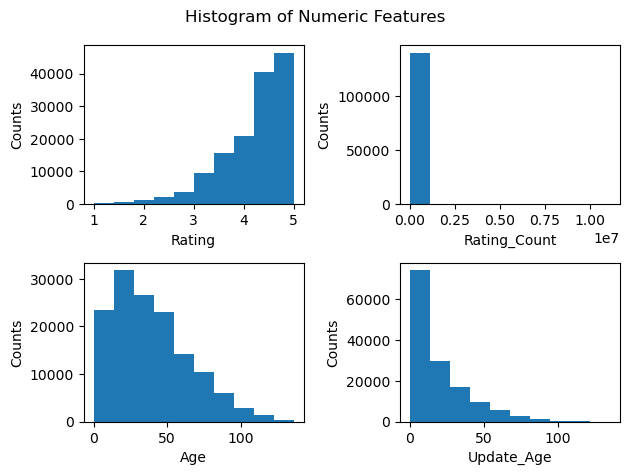

In [211]:
rows, cols = 2, 2
fig, ax = plt.subplots(rows, cols)

for row in range(rows):
    for col in range(cols):
        i=row*cols+col        
        if i< len(hist_plot_columns):
            ax[row, col].hist(EdApp_df[hist_plot_columns[i]])
            ax[row, col].set(xlabel=hist_plot_columns[i], ylabel='Counts')
        if i>= len(bar_plot_columns):
            ax[row, col].axis('off')

plt.suptitle('Histogram of Numeric Features')          
plt.tight_layout(w_pad=1)
plt.show()


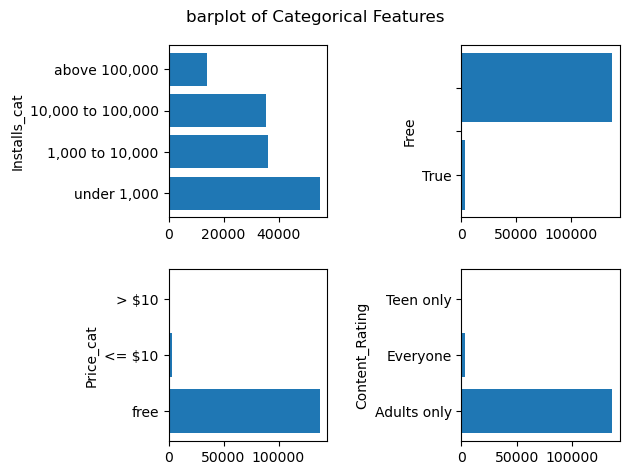

In [212]:
rows, cols =2,2
fig, ax = plt.subplots(rows, cols)

for row in range(rows):
    for col in range(cols):
        i=row*cols+col
        if i< len(bar_plot_columns):
            ax[row, col].barh(EdApp_df[bar_plot_columns[i]].value_counts().index,EdApp_df[bar_plot_columns[i]].value_counts())
            ax[row, col].set(ylabel=bar_plot_columns[i],yticklabels=EdApp_df[bar_plot_columns[i]].value_counts().sort_index().index)
        if i>= len(bar_plot_columns):
            ax[row, col].axis('off')
            
plt.suptitle('barplot of Categorical Features')        
plt.tight_layout(w_pad=2,h_pad=2)
plt.show()


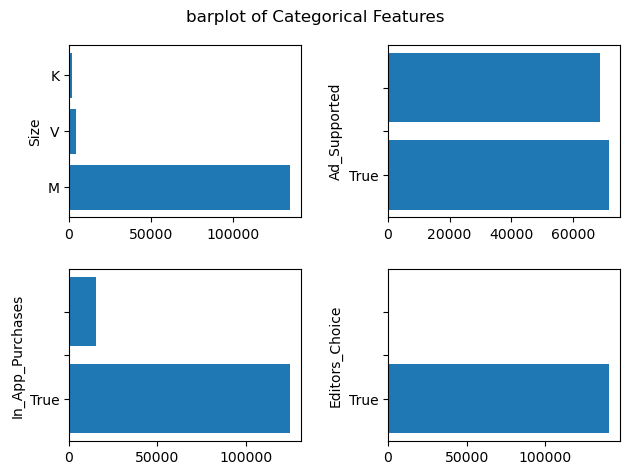

In [213]:
bar_plot_columns=['Size','Ad_Supported','In_App_Purchases', 'Editors_Choice']

rows, cols = 2,2
fig, ax = plt.subplots(rows, cols)

for row in range(rows):
    for col in range(cols):
        i=row*cols+col
        if i< len(bar_plot_columns):
            ax[row, col].barh(EdApp_df[bar_plot_columns[i]].value_counts().index,EdApp_df[bar_plot_columns[i]].value_counts())
            ax[row, col].set(ylabel=bar_plot_columns[i],yticklabels=EdApp_df[bar_plot_columns[i]].value_counts().index)
        if i>= len(bar_plot_columns):
            ax[row, col].axis('off')
            
plt.suptitle('barplot of Categorical Features')        
plt.tight_layout(w_pad=2,h_pad=2)
plt.show()


## OrdinalEncoding Size, Installs

In [177]:
EdApp_df.head()

,App_Name,Rating,Rating_Count,Installs,Free,Price,Size,Content_Rating,Ad_Supported,In_App_Purchases,Editors_Choice,Installs_cat,Price_cat,Age,Update_Age
3,Triple Point Academy,5.0,5.0,10,True,0.0,M,Everyone,False,False,False,"under 1,000",free,8,0
7,Interact 3,2.6,21.0,1000,True,0.0,M,Everyone,False,False,False,"1,000 to 10,000",free,45,45
10,วัสดุสัมผัสอาหาร,4.0,8.0,100,True,0.0,M,Everyone,False,False,False,"under 1,000",free,68,68
13,"Swedish Game: Word Game, Vocabulary Game",4.4,53.0,10000,True,0.0,V,Everyone,True,True,False,"10,000 to 100,000",free,44,9
15,SensorLab,5.0,6.0,100,True,0.0,M,Everyone,False,False,False,"under 1,000",free,24,23


In [178]:
##OrdinalEncoder Installs with
#   1,000 to 10,000 = 1
# 10,000 to 100,000 = 2
#  under 1,000      = 0   
# above 100,000     = 3  

##OrdinalEncoder Size with M=0, V=1,K=2


from category_encoders import OrdinalEncoder

maplist_oe = [{'col': 'Installs_cat','mapping': {'under 1,000': 0, '1,000 to 10,000': 1,'10,000 to 100,000':2,'above 100,000':3}},\
              {'col': 'Size', 'mapping':{'M': 0, 'V': 1,'K':2}},\
              {'col': 'Price_cat', 'mapping':{'free': 0, '<= $10': 1,'> $10':2}}]

enc_oe = OrdinalEncoder(mapping=maplist_oe)
EdApp_df=enc_oe.fit_transform(EdApp_df)

(140424, 17)


,App_Name,Rating,Rating_Count,Installs,Price,Size,Installs_cat,Price_cat,Age,Update_Age,Content_Rating_cat,Free,Ad_Supported,In_App_Purchases,Editors_Choice,Content_Rating_Everyone,Content_Rating_Teen only
3,Triple Point Academy,5.0,5.0,10,0.0,0,0,0,8,0,Everyone,1.0,0.0,0.0,0.0,1.0,0.0
7,Interact 3,2.6,21.0,1000,0.0,0,1,0,45,45,Everyone,1.0,0.0,0.0,0.0,1.0,0.0
10,วัสดุสัมผัสอาหาร,4.0,8.0,100,0.0,0,0,0,68,68,Everyone,1.0,0.0,0.0,0.0,1.0,0.0
13,"Swedish Game: Word Game, Vocabulary Game",4.4,53.0,10000,0.0,1,2,0,44,9,Everyone,1.0,1.0,1.0,0.0,1.0,0.0
15,SensorLab,5.0,6.0,100,0.0,0,0,0,24,23,Everyone,1.0,0.0,0.0,0.0,1.0,0.0


In [214]:
EdApp_df.to_csv('EdApp_cleaned_Non_encoded.csv')
##dummy encondeing 'Free','Ad_Supported','In_App_Purchases','Editors_Choice'

EdApp_df['Content_Rating_cat']=EdApp_df['Content_Rating']
columns_be=['Free','Ad_Supported','In_App_Purchases','Editors_Choice','Content_Rating']                   
EdApp_df = pd.get_dummies(EdApp_df,columns=columns_be,drop_first=True,dtype=float)


EdApp_df.rename(columns={'Free_True':'Free',\
                         'Ad_Supported_True':'Ad_Supported',\
                         'In_App_Purchases_True':'In_App_Purchases',\
                         'Editors_Choice_True':'Editors_Choice'}, inplace=True)
print(EdApp_df.shape)
EdApp_df.head()


(140424, 17)


,App_Name,Rating,Rating_Count,Installs,Price,Size,Installs_cat,Price_cat,Age,Update_Age,Content_Rating_cat,Free,Ad_Supported,In_App_Purchases,Editors_Choice,Content_Rating_Everyone,Content_Rating_Teen only
3,Triple Point Academy,5.0,5.0,10,0.0,M,"under 1,000",free,8,0,Everyone,1.0,0.0,0.0,0.0,1.0,0.0
7,Interact 3,2.6,21.0,1000,0.0,M,"1,000 to 10,000",free,45,45,Everyone,1.0,0.0,0.0,0.0,1.0,0.0
10,วัสดุสัมผัสอาหาร,4.0,8.0,100,0.0,M,"under 1,000",free,68,68,Everyone,1.0,0.0,0.0,0.0,1.0,0.0
13,"Swedish Game: Word Game, Vocabulary Game",4.4,53.0,10000,0.0,V,"10,000 to 100,000",free,44,9,Everyone,1.0,1.0,1.0,0.0,1.0,0.0
15,SensorLab,5.0,6.0,100,0.0,M,"under 1,000",free,24,23,Everyone,1.0,0.0,0.0,0.0,1.0,0.0


## Scale Rating with Log(Rating_count)

In [215]:
##check on the distribution of Rating_Count.
bins=[-np.inf,100,1000,10000,100000,np.inf]
counts=['< 100','100-1,000','1,000-10,000','10,000-100,000','> 100,000']
a,b,_=plt.hist(EdApp_df['Rating_Count'],bins=bins)
plt.close()

log_rating_count_freq=pd.DataFrame(list(zip(counts,np.log(a))),columns=['Rating_Counts', 'Log_Freq'])

##compare Rating_count and Log_Rating_count
print(pd.DataFrame(list(zip(counts,a.astype('int'))),columns=['Rating_Counts', 'Freq']))
print('\n\n')
print(log_rating_count_freq)

##pd.cut Rating_Count into bins and then scale Rating with log_rating_count_freq

EdApp_df['Rating_Count_Cat']=pd.cut(EdApp_df['Rating_Count'],bins,labels=counts)

EdApp_df['Rating_Scaled']=np.nan

for index,row in log_rating_count_freq.iterrows():
    EdApp_df.loc[EdApp_df['Rating_Count_Cat']==row.Rating_Counts,'Rating_Scaled']\
    =EdApp_df.loc[EdApp_df['Rating_Count_Cat']==row.Rating_Counts,'Rating']/row.Log_Freq

##drop 
EdApp_df.drop(['Rating_Count_Cat'],axis=1,inplace=True)

    Rating_Counts    Freq
0           < 100  101952
1       100-1,000   29139
2    1,000-10,000    7673
3  10,000-100,000    1494
4       > 100,000     166



    Rating_Counts   Log_Freq
0           < 100  11.532257
1       100-1,000  10.279833
2    1,000-10,000   8.945463
3  10,000-100,000   7.309212
4       > 100,000   5.111988


In [216]:
###categorize Rating_Scaled_cat into five classes

labels=['1','2','3','4','5']
EdApp_df['Rating_Scaled_cat']=pd.cut(EdApp_df['Rating_Scaled'],bins=5,right=True,labels=labels)
EdApp_df['Rating_Scaled_cat'].value_counts().sort_index().values


array([  8169, 115338,  16130,    634,    153], dtype=int64)

In [217]:
EdApp_df.head()

,App_Name,Rating,Rating_Count,Installs,Price,Size,Installs_cat,Price_cat,Age,Update_Age,Content_Rating_cat,Free,Ad_Supported,In_App_Purchases,Editors_Choice,Content_Rating_Everyone,Content_Rating_Teen only,Rating_Scaled,Rating_Scaled_cat
3,Triple Point Academy,5.0,5.0,10,0.0,M,"under 1,000",free,8,0,Everyone,1.0,0.0,0.0,0.0,1.0,0.0,0.433566,2
7,Interact 3,2.6,21.0,1000,0.0,M,"1,000 to 10,000",free,45,45,Everyone,1.0,0.0,0.0,0.0,1.0,0.0,0.225455,1
10,วัสดุสัมผัสอาหาร,4.0,8.0,100,0.0,M,"under 1,000",free,68,68,Everyone,1.0,0.0,0.0,0.0,1.0,0.0,0.346853,2
13,"Swedish Game: Word Game, Vocabulary Game",4.4,53.0,10000,0.0,V,"10,000 to 100,000",free,44,9,Everyone,1.0,1.0,1.0,0.0,1.0,0.0,0.381538,2
15,SensorLab,5.0,6.0,100,0.0,M,"under 1,000",free,24,23,Everyone,1.0,0.0,0.0,0.0,1.0,0.0,0.433566,2


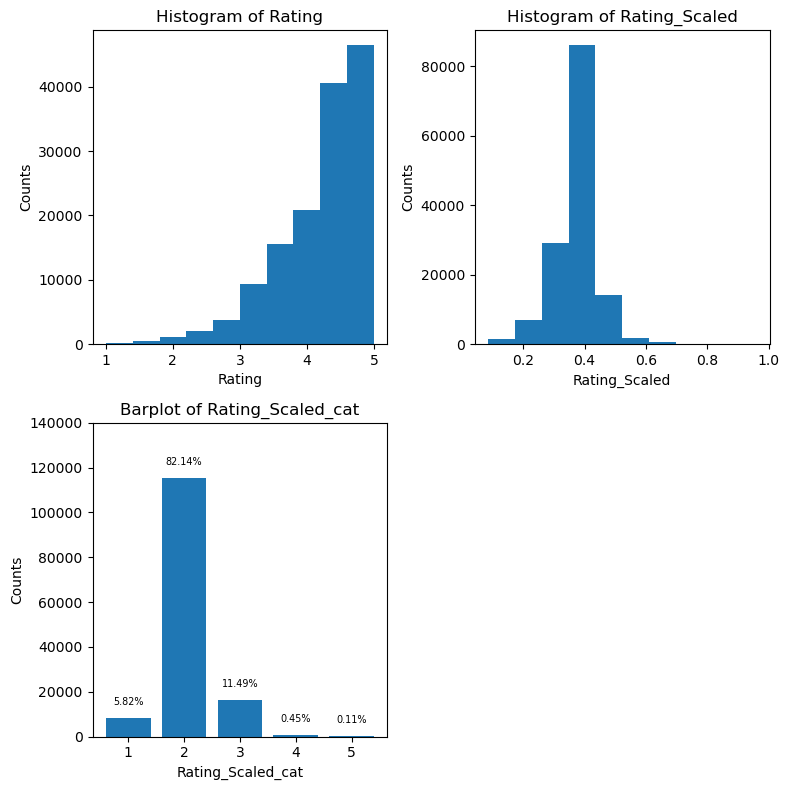

In [210]:
hist_plot_columns=['Rating','Rating_Scaled']

fig, ax = plt.subplots(2,2,figsize=(8,8))

for col in range(2):      
        ax[0,col].hist(EdApp_df[hist_plot_columns[col]])
        ax[0,col].set(xlabel=hist_plot_columns[col], ylabel='Counts')
        ax[0,col].set_title('Histogram of ' + hist_plot_columns[col])
         


bars=ax[1,0].bar([1,2,3,4,5],EdApp_df['Rating_Scaled_cat'].value_counts().sort_index().values)
ax[1,0].set(xlabel='Rating_Scaled_cat', ylabel='Counts',xticks=[1,2,3,4,5],ylim=(0,140000))
ax[1,0].set_title('Barplot of Rating_Scaled_cat')
for bar in bars: 
    height = round(bar.get_height()/EdApp_df.shape[0]*100,2)
    ax[1,0].annotate(f'{height}%', xy=(bar.get_x() + bar.get_width() / 2, height), 
                     xytext=(bar.get_x() + bar.get_width() / 2, bar.get_height()+5000),
                     ha='center', va='bottom',fontsize='x-small')
ax[1,1].axis('off')
plt.tight_layout(w_pad=1)
plt.show()

In [211]:
EdApp_df['Rating_Scaled_cat']=EdApp_df['Rating_Scaled_cat'].astype('category')
EdApp_df.to_csv('EdApp_cleaned_encoded.csv')

# 3. EDA steps

In [5]:
EdApp_df= pd.read_csv('EdApp_cleaned_encoded.csv', index_col=0)
EdApp_df.columns

Index(['App_Name', 'Rating', 'Rating_Count', 'Installs', 'Price', 'Size',
       'Installs_cat', 'Price_cat', 'Age', 'Update_Age', 'Content_Rating_cat',
       'Free', 'Ad_Supported', 'In_App_Purchases', 'Editors_Choice',
       'Content_Rating_Everyone', 'Content_Rating_Teen only', 'Rating_Scaled',
       'Rating_Scaled_cat'],
      dtype='object')

## 3.1 Heatmaps

In [132]:
EdApp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140424 entries, 3 to 261917
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   App_Name                  140424 non-null  object 
 1   Rating                    140424 non-null  float64
 2   Rating_Count              140424 non-null  float64
 3   Installs                  140424 non-null  int64  
 4   Price                     140424 non-null  float64
 5   Size                      140424 non-null  int64  
 6   Installs_cat              140424 non-null  int64  
 7   Price_cat                 140424 non-null  int64  
 8   Age                       140424 non-null  int64  
 9   Update_Age                140424 non-null  int64  
 10  Content_Rating_cat        140424 non-null  object 
 11  Free                      140424 non-null  float64
 12  Ad_Supported              140424 non-null  float64
 13  In_App_Purchases          140424 non-null  float6

Text(27, 8, 'Only strength of \n\n correlations >= 0.2\n\n are plotted')

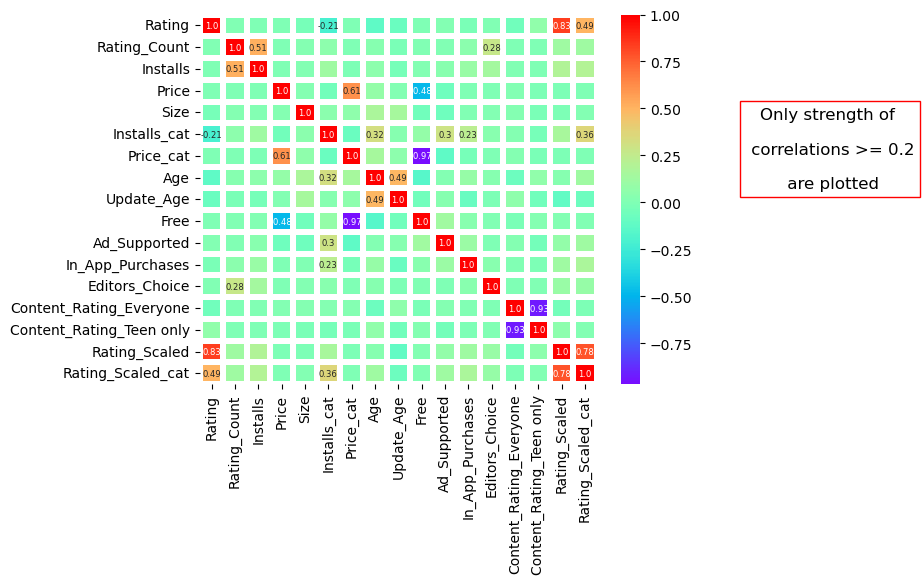

In [223]:
# Generate annotation labels array (of the same size as the heatmap data)- filling cells you don't want to annotate with an empty string ''
corr_df=EdApp_df.drop('Content_Rating_cat',axis=1).iloc[:,1:].corr()
annot_labels = np.empty_like(corr_df, dtype=float)

rows,cols=corr_df.shape

for i in range(rows):
    for j in range(cols):
        val=corr_df.iloc[i,j]
        if (val>=0.2 or val<= -0.2):
            annot_labels[i,j]=val
        else: 
            annot_labels[i,j]=np.nan
annot_labels=np.round(annot_labels,2)
annot_labels = np.where(np.isnan(annot_labels), '', annot_labels)

g=sns.heatmap(corr_df, annot=annot_labels, linewidths=3, center=0,\
            cmap='rainbow',fmt='', annot_kws={"size": 25 / np.sqrt(len(corr_df))});
g.text(x=27,y=8,s="Only strength of \n\n correlations >= 0.2\n\n are plotted",horizontalalignment='center',
       fontsize='large',bbox=dict(facecolor='none', edgecolor='red'))
#
#plt.savefig('heatmap.png',dpi=100)

In [224]:
import os
plt.savefig('heatmap.jpg')
os.getcwd()

'C:\\Users\\hyang\\Desktop\\springboard data science career track\\Springboard\\Capstone project_2'

<Figure size 640x480 with 0 Axes>

## 3.2.  Visual Exploration when Rating is Treated as Numerical

### 3.2.1 Rating vs Continous Features

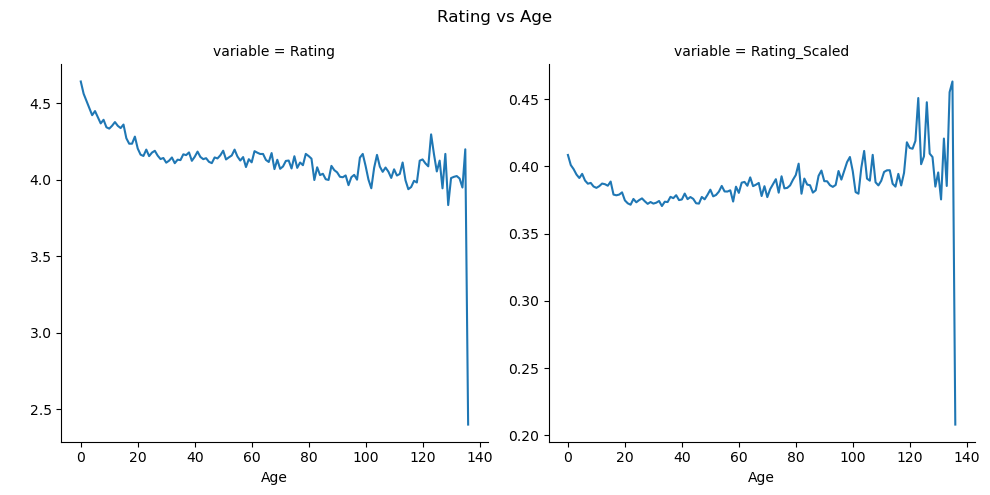

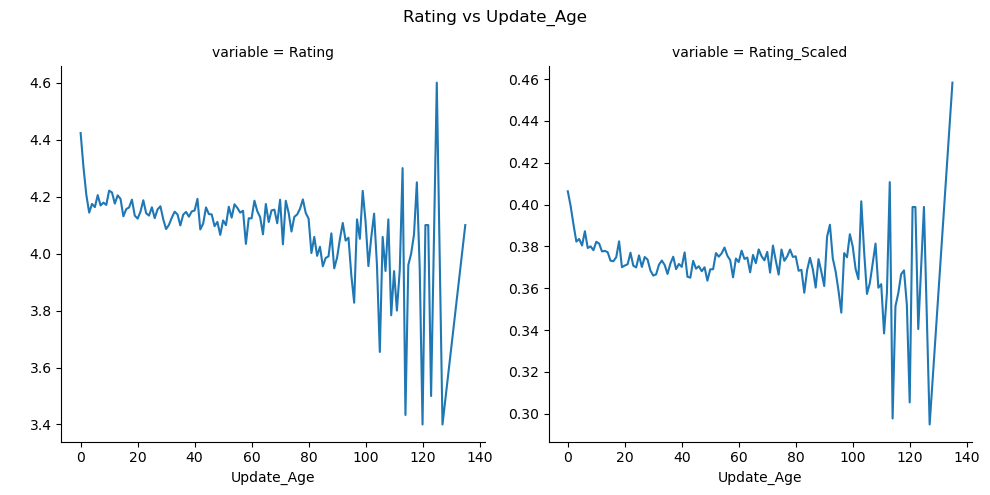

In [289]:
line_plot_columns=['Age', 'Update_Age']


for i in range(len(line_plot_columns)):
    df_long = EdApp_df.melt(id_vars=line_plot_columns[i], value_vars=['Rating','Rating_Scaled'])
    g=sns.relplot(x=line_plot_columns[i], y='value', col='variable', data=df_long, kind='line',ci=None,facet_kws={'sharey': False, 'sharex': True})
    g.set_xlabels(line_plot_columns[i])
    g.set_ylabels('   ')
    g.set_xlim=(0,150)
    g.fig.suptitle('Rating vs '+ line_plot_columns[i])

    plt.tight_layout()
    plt.show()

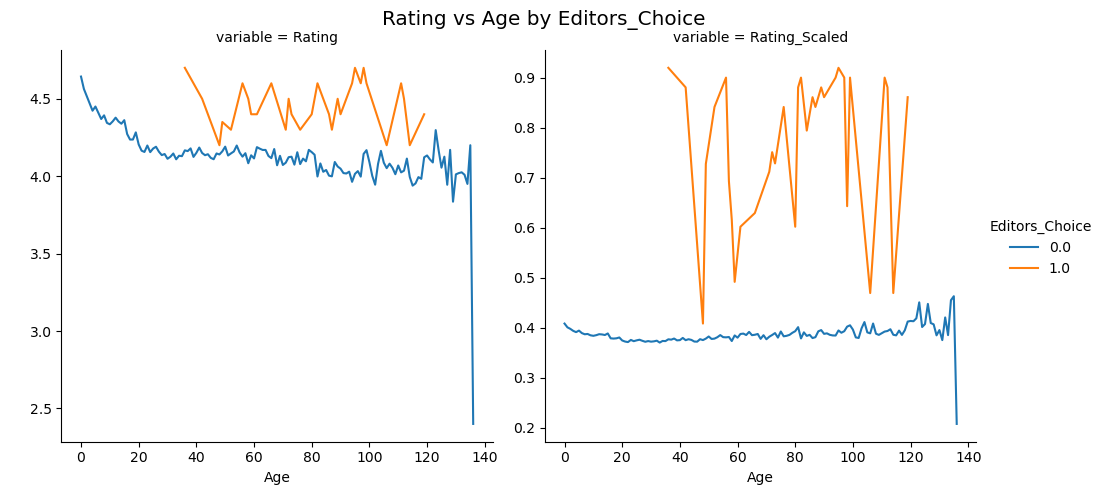

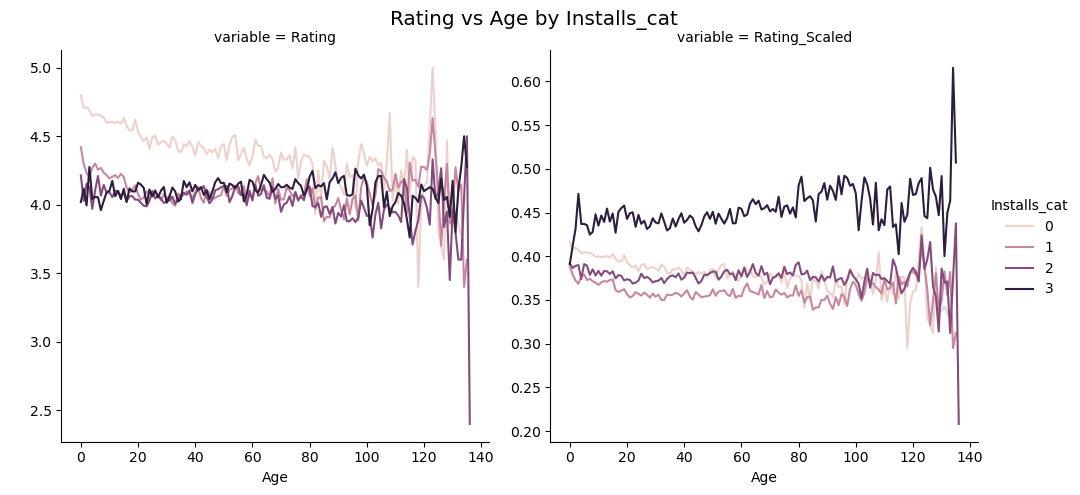

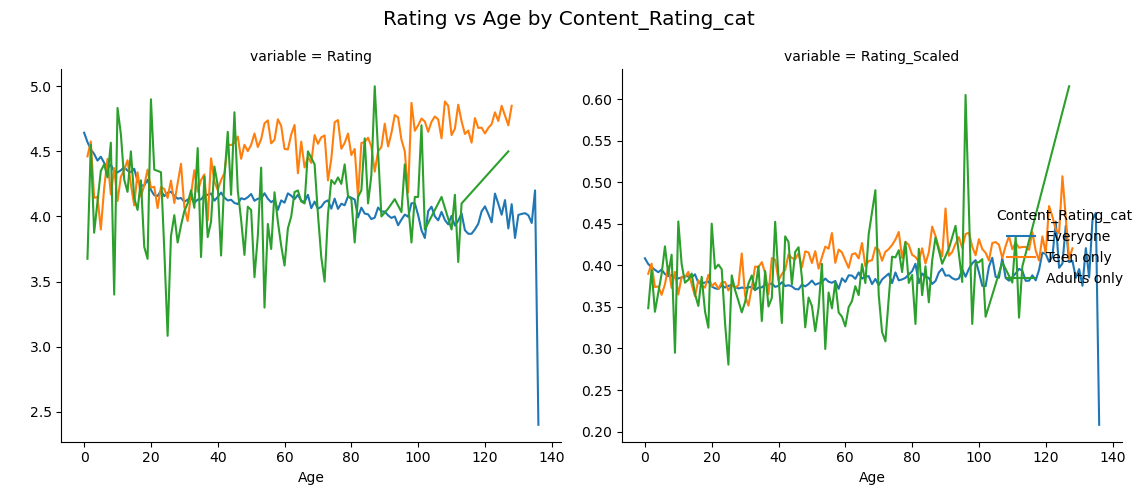

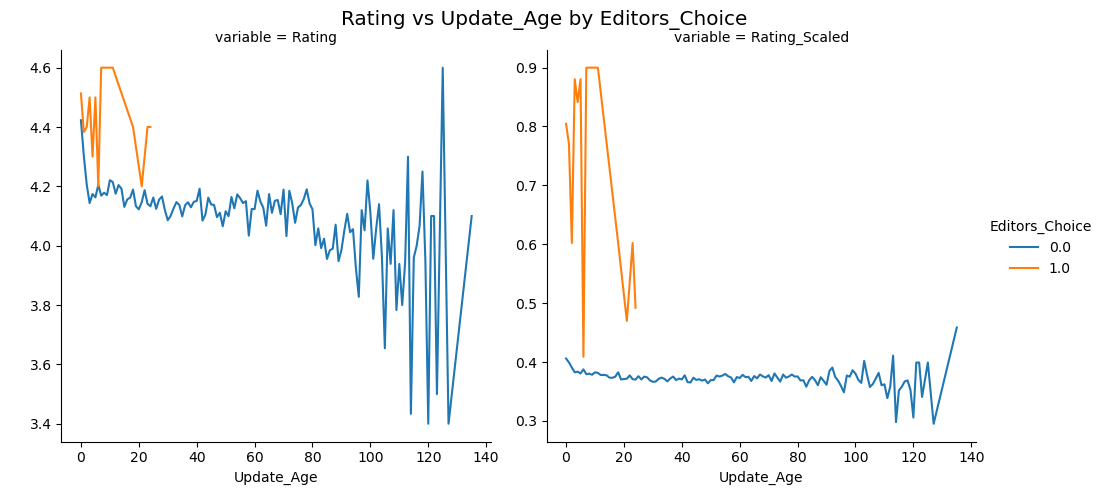

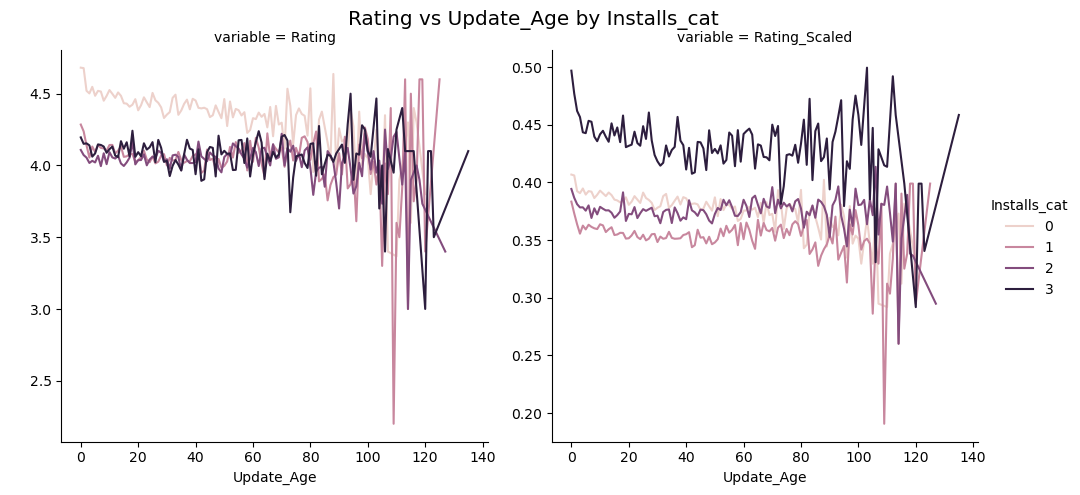

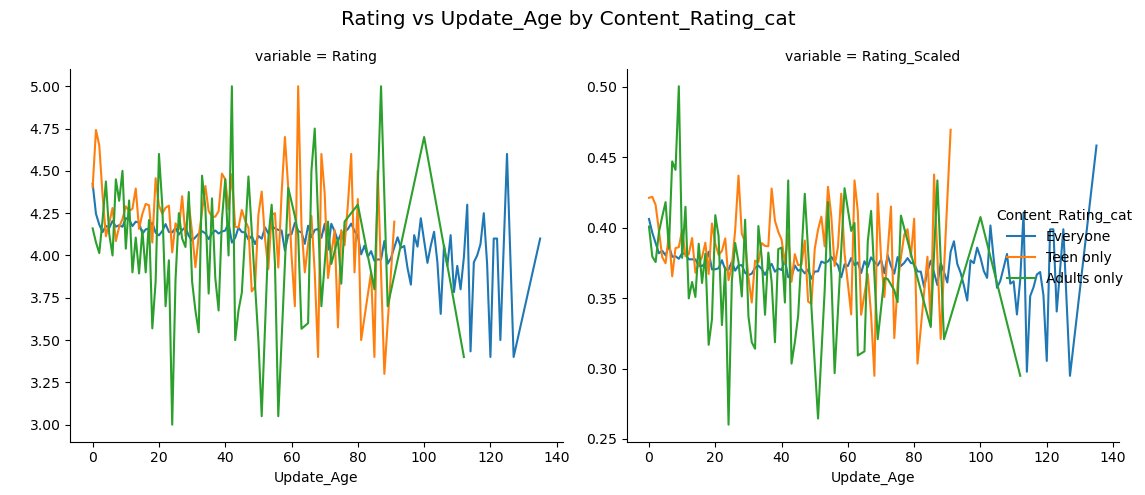

In [294]:
line_plot_columns=['Age', 'Update_Age']
add_columns=['Editors_Choice','Installs_cat', 'Content_Rating_cat']

for i in range(len(line_plot_columns)):
    for j in range(len(add_columns)):
        df_long = EdApp_df.melt(id_vars=[line_plot_columns[i],add_columns[j]], value_vars=['Rating','Rating_Scaled'])
        g=sns.relplot(x=line_plot_columns[i], y='value', col='variable',hue=add_columns[j],\
                      data=df_long, kind='line',ci=None,facet_kws={'sharey': False, 'sharex': True})
        g.set_xlabels(line_plot_columns[i])
        g.set_ylabels('    ')
        g.fig.subplots_adjust(top=0.9) 
        g.fig.suptitle('Rating vs '+ line_plot_columns[i]+' by '+add_columns[j],fontsize='x-large')
  
    plt.tight_layout()
    plt.show()

### 3.2.2 Rating vs Categorical Features

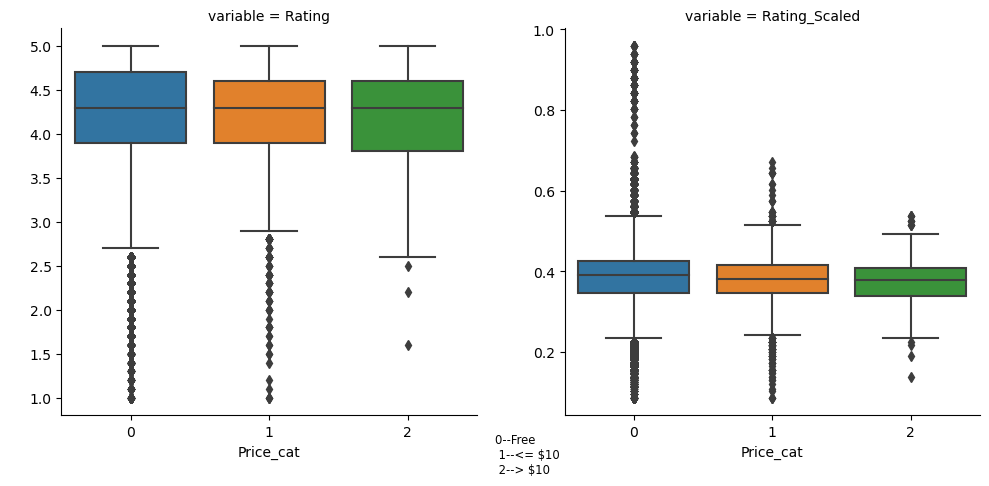

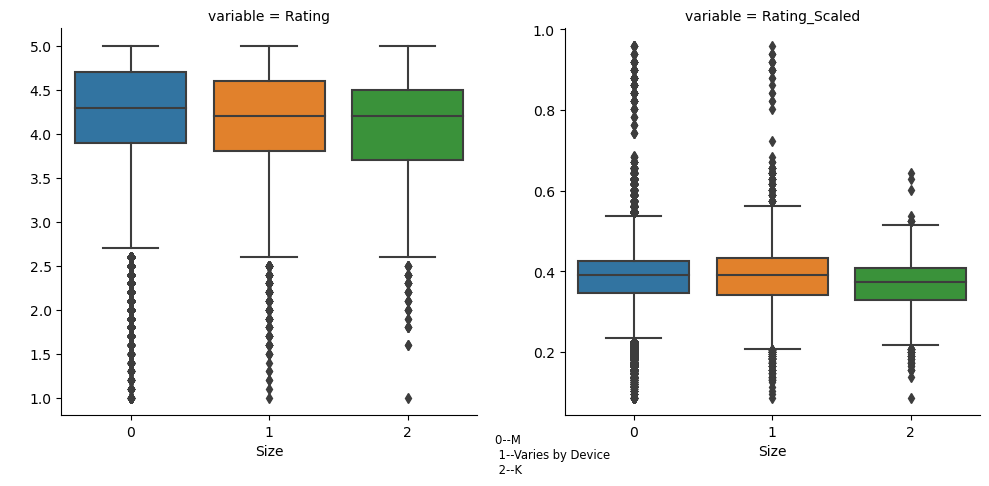

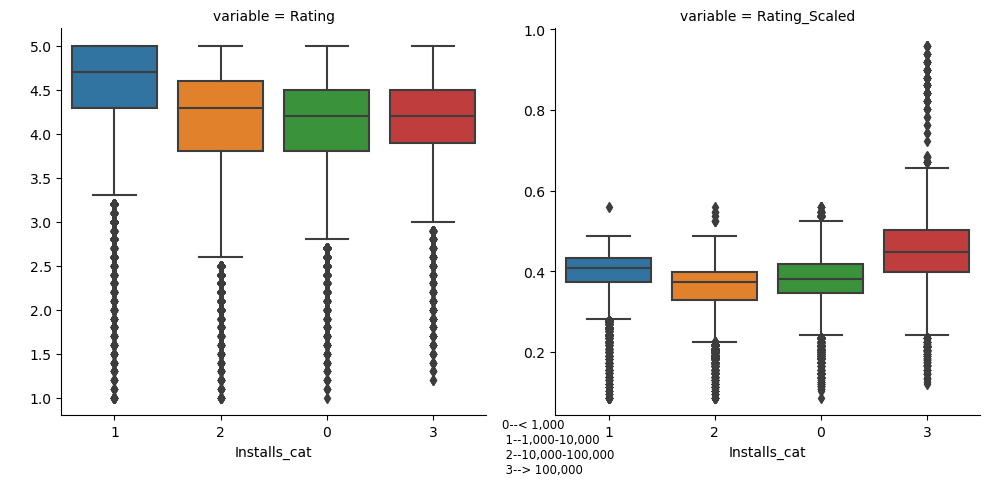

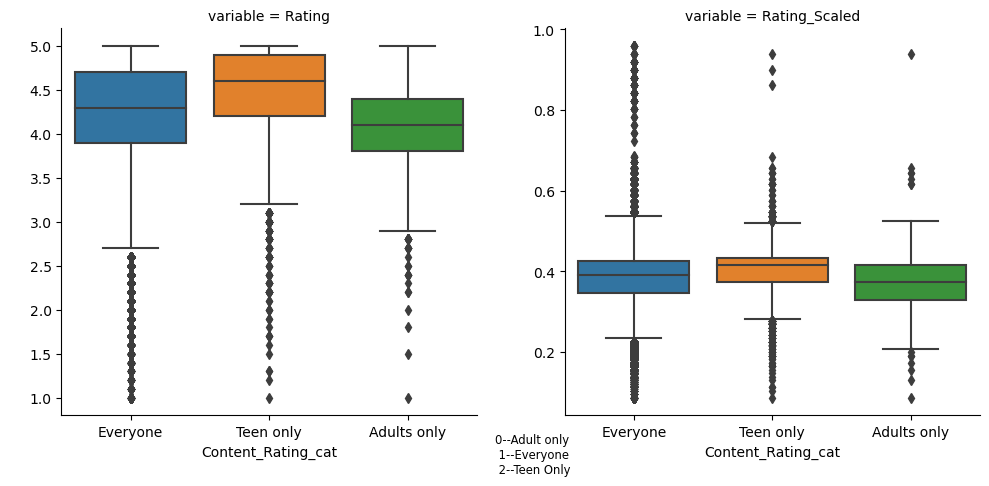

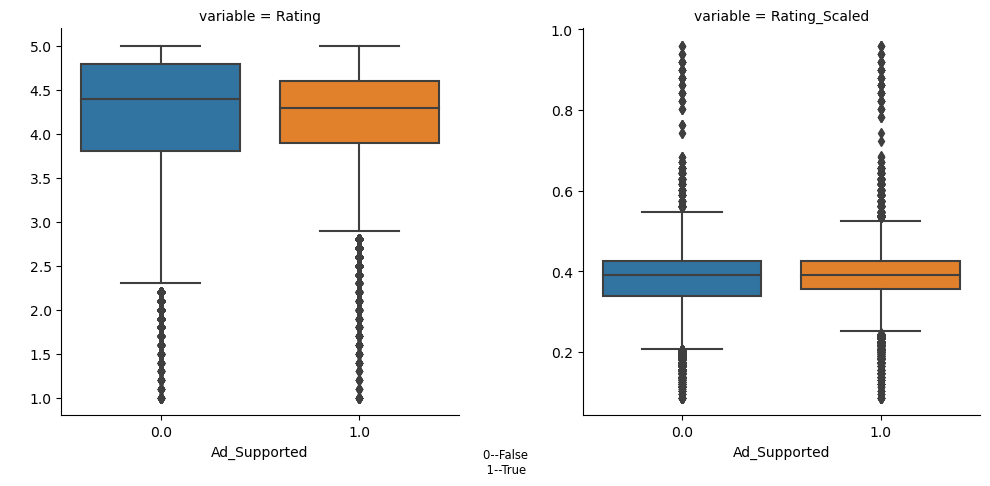

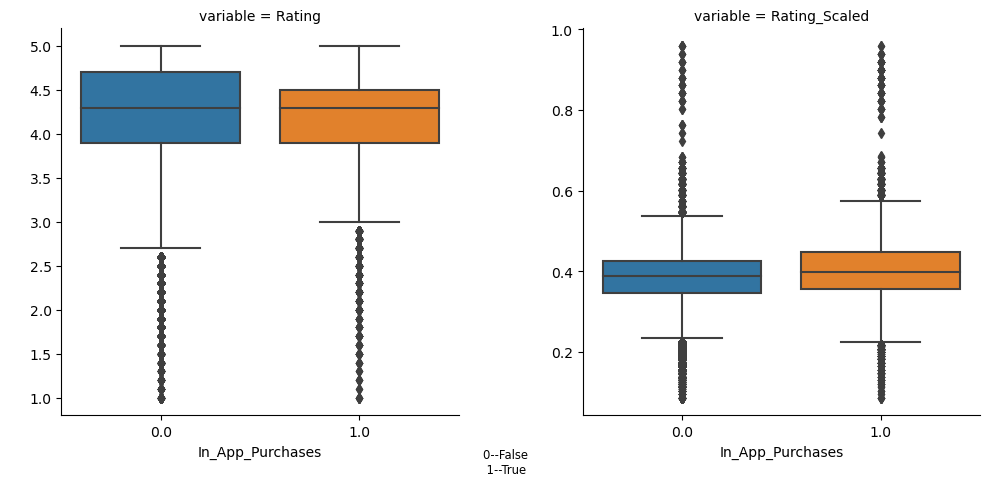

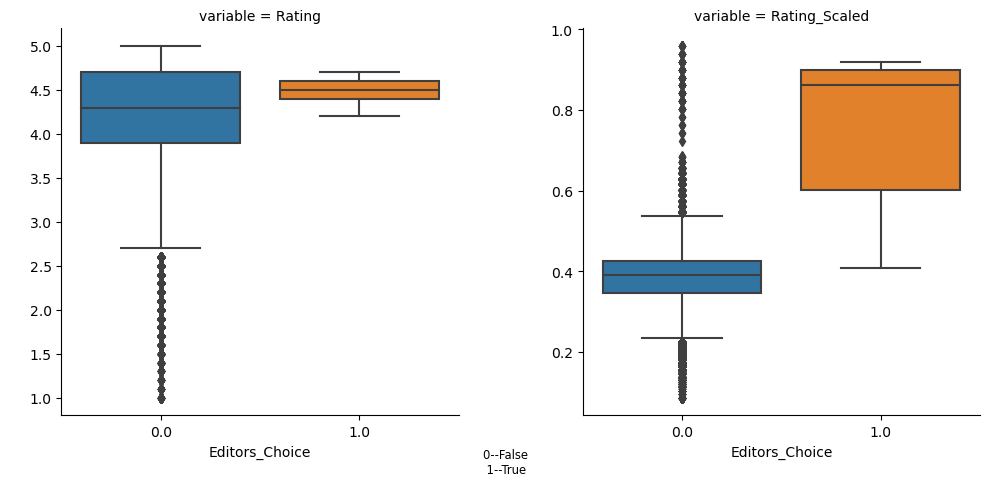

In [47]:
box_plot_columns=['Price_cat','Size','Installs_cat', 'Content_Rating_cat','Ad_Supported','In_App_Purchases', 'Editors_Choice']


for i in range(len(box_plot_columns)):
    df_long = EdApp_df.melt(id_vars=box_plot_columns[i], value_vars=['Rating','Rating_Scaled'])
    g=sns.catplot(x=box_plot_columns[i], y='value', col='variable', data=df_long, kind='box',sharey=False)
    g.set_xlabels(box_plot_columns[i])
    g.set_ylabels('    ')
    g.set_xticklabels(EdApp_df[box_plot_columns[i]].value_counts().index)
    if i==0:
        plt.text(-1,-0.1, '0--Free \n 1--<= $10 \n 2--> $10',fontsize='small')
    if i==1:
        plt.text(-1,-0.1, '0--M \n 1--Varies by Device \n 2--K',fontsize='small')
    if i==2:
        plt.text(-1,-0.1, '0--< 1,000 \n 1--1,000-10,000 \n 2--10,000-100,000 \n 3--> 100,000',fontsize='small')
    if i==3:
        plt.text(-1,-0.1, '0--Adult only \n 1--Everyone \n 2--Teen Only',fontsize='small')
    if i in [4,5,6]:
        plt.text(-1,-0.1, '0--False \n 1--True',fontsize='small')

    plt.tight_layout()
    plt.show()

## 3.3 Visual Exploration when Rating is Treated as Categorical 

### 3.3.1. Rating_Scaled_cat vs Continous Features

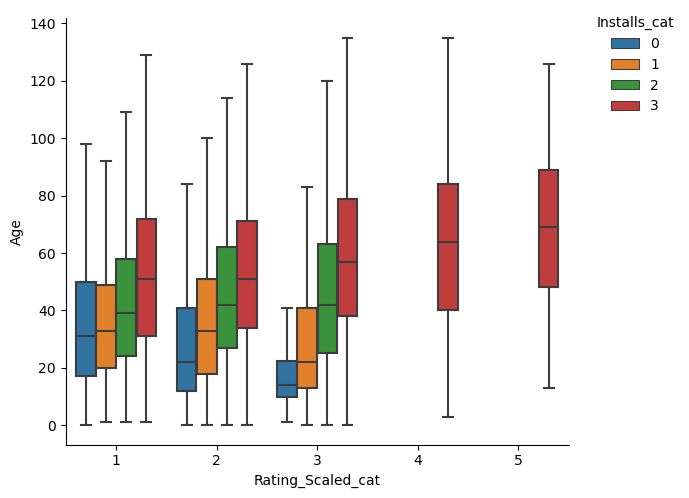

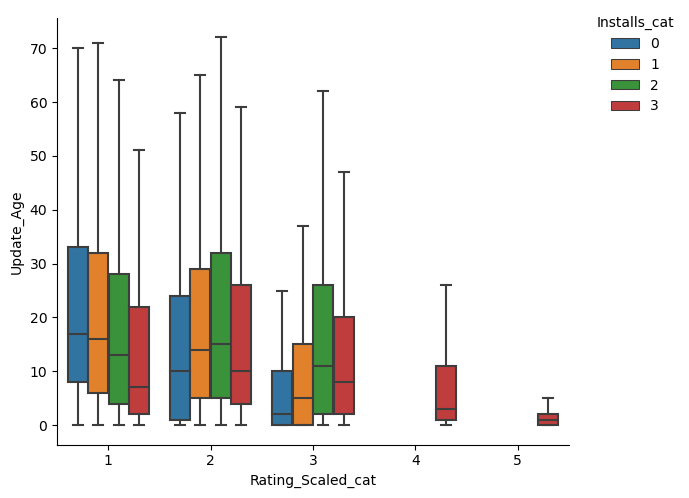

In [285]:
box_plot_columns=['Age', 'Update_Age']


for i in range(len(box_plot_columns)):
    g=sns.catplot(data=EdApp_df,x='Rating_Scaled_cat', y=box_plot_columns[i], hue='Installs_cat',kind='box',sym='')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
#    g.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#    g.set_xlabels('Rating_Scaled_cat')
#    g.set_ylabels(box_plot_columns[i])
    plt.tight_layout()
    plt.show()

### 3.3.2. Rating_Scaled_cat vs Categorical Features

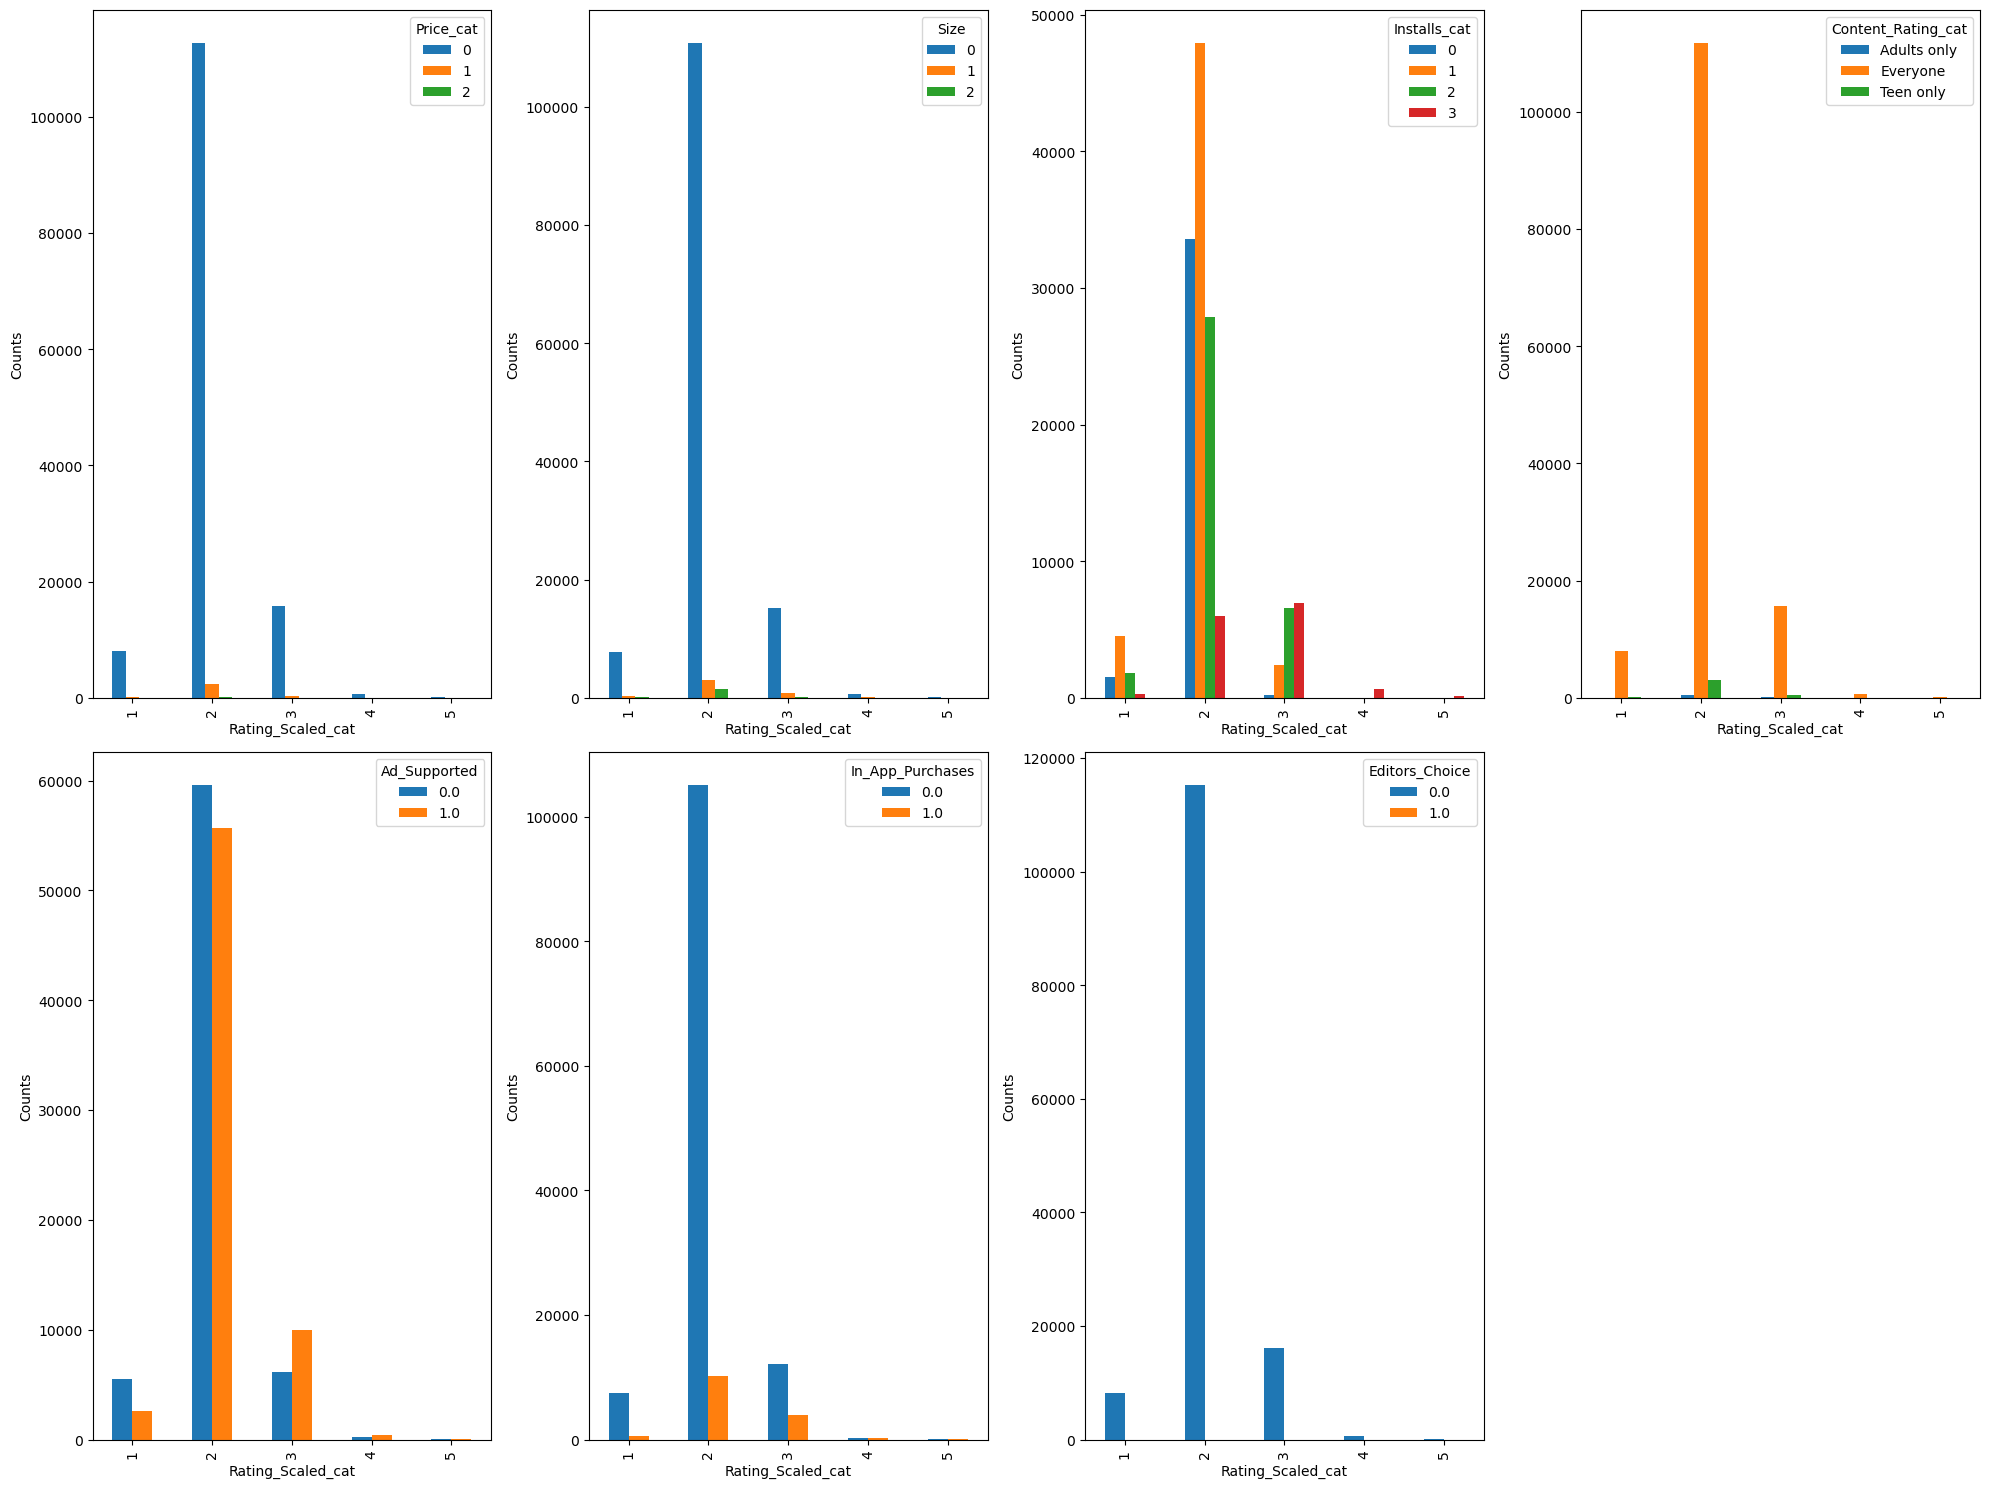

In [295]:
bar_plot_columns=['Price_cat','Size','Installs_cat', 'Content_Rating_cat',
                  'Ad_Supported','In_App_Purchases', 'Editors_Choice']

rows, cols = 2,4
fig, axs = plt.subplots(rows, cols,figsize=(20,15))

for row in range(rows):
    for col in range(cols):
        i=row*cols+col
        ax=axs[row,col]
        if i< len(bar_plot_columns):
            df_plot = EdApp_df.groupby([bar_plot_columns[i],
                                        'Rating_Scaled_cat']).size().reset_index().pivot(columns=bar_plot_columns[i],\
                                                                                 index='Rating_Scaled_cat', values=0)
            df_plot.plot(kind='bar',ax=ax)
            ax.set_ylabel("Counts")
        if i>= len(bar_plot_columns):
            ax.axis('off')
plt.tight_layout()
plt.show()

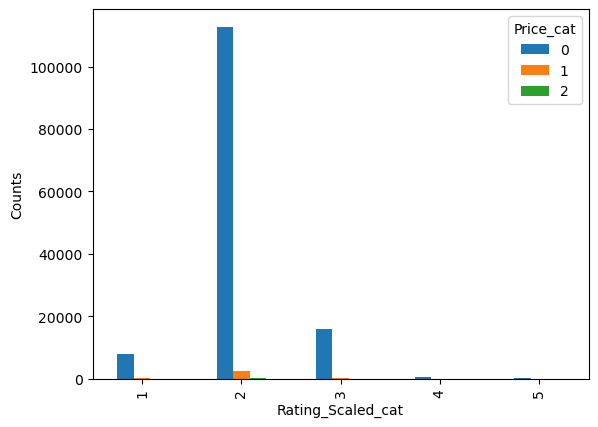

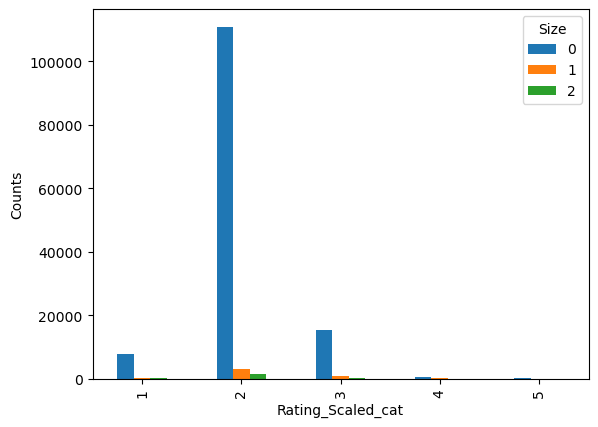

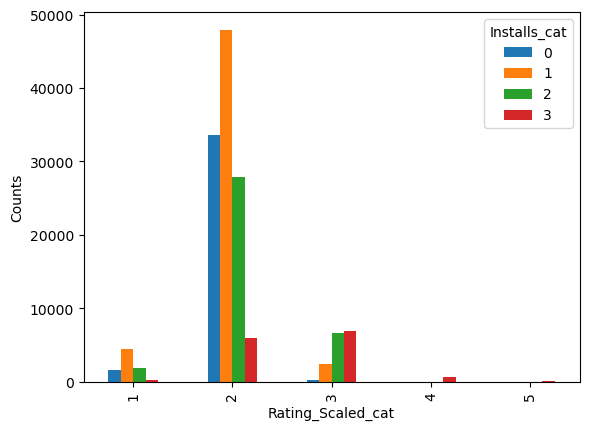

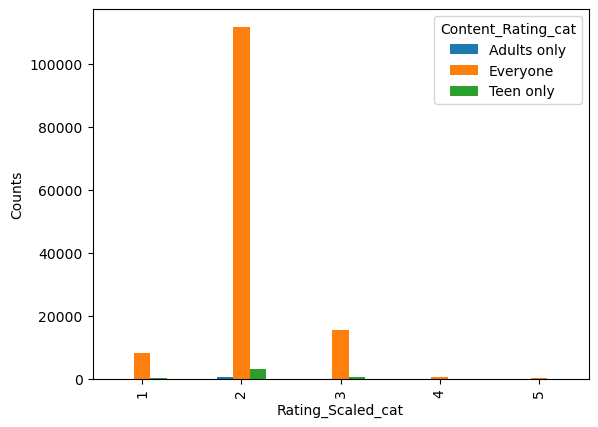

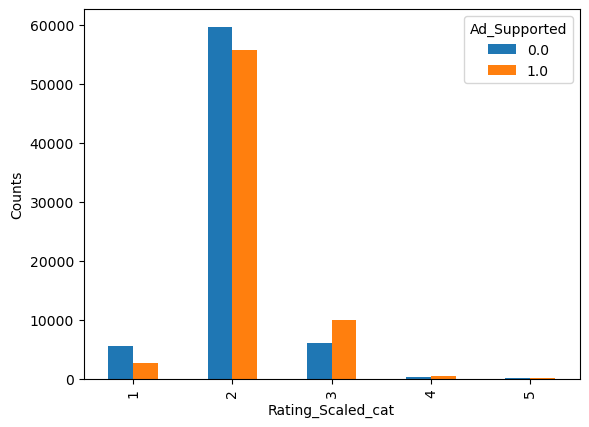

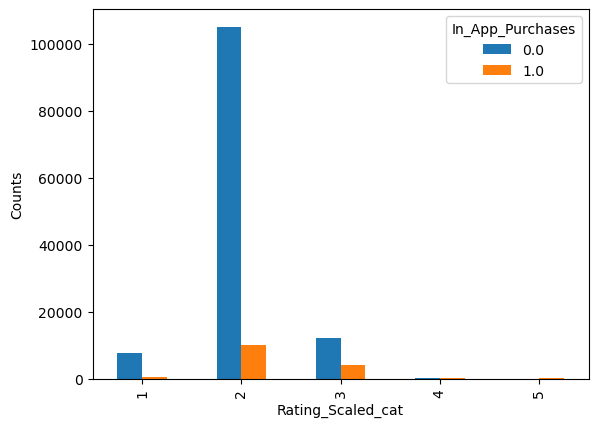

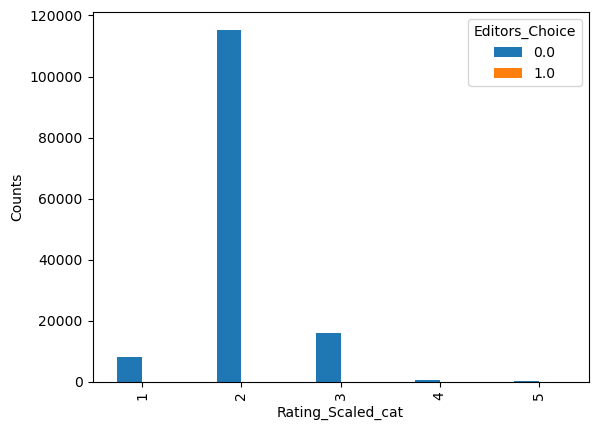

In [286]:

bar_plot_columns=['Price_cat','Size','Installs_cat', 'Content_Rating_cat',
                  'Ad_Supported','In_App_Purchases', 'Editors_Choice']


for i in range(len(bar_plot_columns)):
    df_plot = EdApp_df.groupby([bar_plot_columns[i],\
                                'Rating_Scaled_cat']).size().reset_index().pivot(columns=bar_plot_columns[i],\
                                                                                 index='Rating_Scaled_cat', values=0)
    ax=df_plot.plot(kind='bar')
    ax.set_ylabel("Counts")

# 4. Modeling

In [4]:
EdApp_df= pd.read_csv('EdApp_cleaned_encoded.csv', index_col=0)
EdApp_df.columns

Index(['App_Name', 'Rating', 'Rating_Count', 'Installs', 'Price', 'Size',
       'Installs_cat', 'Price_cat', 'Age', 'Update_Age', 'Content_Rating_cat',
       'Free', 'Ad_Supported', 'In_App_Purchases', 'Editors_Choice',
       'Content_Rating_Everyone', 'Content_Rating_Teen only', 'Rating_Scaled',
       'Rating_Scaled_cat'],
      dtype='object')

In [5]:
EdApp_df.head()

,App_Name,Rating,Rating_Count,Installs,Price,Size,Installs_cat,Price_cat,Age,Update_Age,Content_Rating_cat,Free,Ad_Supported,In_App_Purchases,Editors_Choice,Content_Rating_Everyone,Content_Rating_Teen only,Rating_Scaled,Rating_Scaled_cat
3,Triple Point Academy,5.0,5.0,10,0.0,0,0,0,8,0,Everyone,1.0,0.0,0.0,0.0,1.0,0.0,0.433566,2
7,Interact 3,2.6,21.0,1000,0.0,0,1,0,45,45,Everyone,1.0,0.0,0.0,0.0,1.0,0.0,0.225455,1
10,วัสดุสัมผัสอาหาร,4.0,8.0,100,0.0,0,0,0,68,68,Everyone,1.0,0.0,0.0,0.0,1.0,0.0,0.346853,2
13,"Swedish Game: Word Game, Vocabulary Game",4.4,53.0,10000,0.0,1,2,0,44,9,Everyone,1.0,1.0,1.0,0.0,1.0,0.0,0.381538,2
15,SensorLab,5.0,6.0,100,0.0,0,0,0,24,23,Everyone,1.0,0.0,0.0,0.0,1.0,0.0,0.433566,2


In [6]:
EdApp_df.columns

Index(['App_Name', 'Rating', 'Rating_Count', 'Installs', 'Price', 'Size',
       'Installs_cat', 'Price_cat', 'Age', 'Update_Age', 'Content_Rating_cat',
       'Free', 'Ad_Supported', 'In_App_Purchases', 'Editors_Choice',
       'Content_Rating_Everyone', 'Content_Rating_Teen only', 'Rating_Scaled',
       'Rating_Scaled_cat'],
      dtype='object')

In [7]:
EdApp_df_model=EdApp_df[['Size','Installs_cat', 'Price_cat', 'Age', 'Update_Age',\
                         'Free', 'Ad_Supported', 'In_App_Purchases', 'Editors_Choice',\
                         'Content_Rating_Everyone', 'Content_Rating_Teen only', 'Rating_Scaled_cat']]
print(EdApp_df_model.shape)
EdApp_df_model.head()

(140424, 12)


,Size,Installs_cat,Price_cat,Age,Update_Age,Free,Ad_Supported,In_App_Purchases,Editors_Choice,Content_Rating_Everyone,Content_Rating_Teen only,Rating_Scaled_cat
3,0,0,0,8,0,1.0,0.0,0.0,0.0,1.0,0.0,2
7,0,1,0,45,45,1.0,0.0,0.0,0.0,1.0,0.0,1
10,0,0,0,68,68,1.0,0.0,0.0,0.0,1.0,0.0,2
13,1,2,0,44,9,1.0,1.0,1.0,0.0,1.0,0.0,2
15,0,0,0,24,23,1.0,0.0,0.0,0.0,1.0,0.0,2


In [8]:
X=EdApp_df_model.iloc[:,:-1]
y=EdApp_df_model.iloc[:,-1]

In [9]:
#Grouping target into binary 
y.replace(2,1,inplace=True)
y.replace([3,4,5],2,inplace=True)

print(y.value_counts())
print(y.value_counts()/len(y))

Rating_Scaled_cat
1    123507
2     16917
Name: count, dtype: int64
Rating_Scaled_cat
1    0.879529
2    0.120471
Name: count, dtype: float64


In [10]:
le =LabelEncoder()
y=le.fit_transform(y)
#y=le.fit_transform(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y,random_state=123)
print('X_train : ',X_train.shape)
print('X_test : ',X_test.shape)

unique,count=np.unique(y_train, return_counts=True)
print(count)
print('train_test sets are splited with stratification: \n\t training set: {} '.format(count/len(y_train)))
print('train_test sets are splited with stratification: \n\t test set: {} '.format(count/len(y_test)))
np.unique(y_test, return_counts=True)

X_train :  (126381, 11)
X_test :  (14043, 11)
[111156  15225]
train_test sets are splited with stratification: 
	 training set: [0.87953094 0.12046906] 
train_test sets are splited with stratification: 
	 test set: [7.91540269 1.08417005] 


(array([0, 1], dtype=int64), array([12351,  1692], dtype=int64))

In [12]:
scaler=StandardScaler()
X_train[['Age', 'Update_Age']] = scaler.fit_transform(X_train[['Age', 'Update_Age']])
X_test[['Age', 'Update_Age']] = scaler.transform(X_test[['Age', 'Update_Age']])

## 4.1 DecisionTreeClassifier

### 4.1.1.  Base Model 

In [12]:
tree_clf= DecisionTreeClassifier(random_state = 0, max_depth=10,class_weight='balanced') 
tree_clf.fit(X_train,y_train)
y_pred=tree_clf.predict(X_test)

pl = confusion_matrix(y_test,y_pred)
print("Base Model : \n{}".format(pl))

print(classification_report(y_test,y_pred))

#dist=ConfusionMatrixDisplay(confusion_matrix=pl,display_labels=tree_clf.classes_)
#dist.plot()

Base Model : 
[[9101 3250]
 [ 271 1421]]
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     12351
           1       0.30      0.84      0.45      1692

    accuracy                           0.75     14043
   macro avg       0.64      0.79      0.64     14043
weighted avg       0.89      0.75      0.79     14043



In [15]:
#from io import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn import tree

i_plot=0

if i_plot>0:
    dot_data=tree.export_graphviz(tree_clf, out_file=None,feature_names=X.columns)
    graph = pydotplus.graph_from_dot_data(dot_data)
    Image(graph.create_png())

### 4.1.2.  Base Model with Resampling 

In [14]:
pipel = Pipeline([('over1',RandomOverSampler()),
                  ('model',tree_clf)])

c0_under = RandomUnderSampler(sampling_strategy={0:int(count[0]*0.6)},random_state=123)
c1_over = RandomOverSampler(sampling_strategy={1:int(count[1]*1.4)},random_state=123)

pipel = Pipeline([('under0',c0_under),
                  ('over1',c1_over),
                  ('model',tree_clf)])
#print(pipel.get_params().keys())

pipel.fit(X_train,y_train)
y_pred=pipel.predict(X_test)

print("Base Model with Resampling: \n{}".format(classification_report(y_test,y_pred)))


Base Model with Resampling: 
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     12351
           1       0.30      0.84      0.44      1692

    accuracy                           0.74     14043
   macro avg       0.63      0.78      0.63     14043
weighted avg       0.89      0.74      0.78     14043




### 4.1.3 Hyper-params Tuning by GridSearchCV/RandomizedSearchCV


In [13]:
c0_strategy = [{0:int(count[0]*r)} for r in np.linspace(0.1,0.5,num=10)]
c1_strategy = [{1:int(count[1]*r)} for r in np.linspace(1,5,num=10)]

c0_under = RandomUnderSampler(sampling_strategy={0:int(count[0]*0.6)},random_state=123)
c1_over = RandomOverSampler(sampling_strategy={1:int(count[1]*1.4)},random_state=123)

pipel = Pipeline([('under0',c0_under),
                  ('over1',c1_over),
                  ('model',tree_clf)])

param_grid = {'model__max_depth': np.arange(3,30),
#              'model__min_samples_leaf': np.arange(30,100),
              'under0__sampling_strategy': c0_strategy,
              'over1__sampling_strategy': c1_strategy}

In [19]:
%%timeit

random_seed_number=42
np.random.seed(random_seed_number)

i_grid=0
if i_grid==1:
    grid = GridSearchCV(pipel, param_grid, cv=5, n_jobs=-1,scoring='f1_macro') 
    grid.fit(X_train, y_train)
    y_pred=grid.predict(X_test)

    print("Base Model with Resampoling and Hyper-params Tuning: \n{}".format(classification_report(y_test,y_pred)))
    print('\n')
    print("Best Parameters: \n{}".format(grid.best_params_))
    
i_rand=1
if i_rand==1:
    rand = RandomizedSearchCV(pipel, param_grid, cv=5, n_jobs=-1,scoring='f1_macro', n_iter=50,random_state=42) 
    rand.fit(X_train, y_train)
    y_pred=rand.predict(X_test)

    print("Base Model with Resampoling and Hyper-params Tuning: \n{}".format(classification_report(y_test,y_pred)))
    print('\n')
    print("Best Parameters: \n{}".format(rand.best_params_))

Base Model with Resampoling and Hyper-params Tuning: 
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     12351
           1       0.31      0.72      0.43      1692

    accuracy                           0.77     14043
   macro avg       0.63      0.75      0.64     14043
weighted avg       0.88      0.77      0.81     14043



Best Parameters: 
{'under0__sampling_strategy': {0: 55578}, 'over1__sampling_strategy': {1: 55825}, 'model__max_depth': 18}


## 4.2  RandomForest Classifier

### 4.2.1. RandomForest Model with Resampling

In [14]:
# Fit a Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100,max_features="sqrt",random_state=42,
                             criterion='gini',class_weight='balanced')

c0_under = RandomUnderSampler(sampling_strategy={0:int(count[0]*0.6)},random_state=123)
c1_over = RandomOverSampler(sampling_strategy={1:int(count[1]*1.4)},random_state=123)

pipel = Pipeline([('under0',c0_under),
                  ('over1',c1_over),
                  ('model',rf_clf)])
#print(pipel.get_params().keys())

pipel.fit(X_train,y_train)
y_pred=pipel.predict(X_test)
pl = confusion_matrix(y_test,y_pred)

print("RandomForest Model with Resampling: \n{}".format(classification_report(y_test,y_pred)))

RandomForest Model with Resampling: 
              precision    recall  f1-score   support

           0       0.94      0.84      0.89     12351
           1       0.34      0.61      0.44      1692

    accuracy                           0.81     14043
   macro avg       0.64      0.72      0.66     14043
weighted avg       0.87      0.81      0.83     14043



### 4.2.2. RandomForest Model with Resampling and Hyper_params Tuning

In [15]:
%%timeit

# Fit a Random Forest model
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]

c0_strategy = [{0:int(count[0]*r)} for r in np.linspace(0.1,0.5,num=10)]
c1_strategy = [{1:int(count[1]*r)} for r in np.linspace(1,5,num=10)]

c0_under = RandomUnderSampler(sampling_strategy={0:int(count[0]*0.6)},random_state=123)
c1_over = RandomOverSampler(sampling_strategy={1:int(count[1]*1.4)},random_state=123)

pipel = Pipeline([('under0',c0_under),
                  ('over1',c1_over),
                  ('model',rf_clf)])


param_grid = {'model__n_estimators': n_est, 
              'model__criterion':['gini','entropy'],
              'under0__sampling_strategy': c0_strategy,
              'over1__sampling_strategy': c1_strategy}

i_grid=0
if i_grid==1:
    grid = GridSearchCV(pipel, param_grid, cv=5,scoring='f1_macro',n_jobs=-1) 
    grid.fit(X_train, y_train) 
    y_pred=grid.predict(X_test)
    pl = confusion_matrix(y_test,y_pred)

    print("RandomForest Model with Resampoling and Hyper-params Tuning: \n{}".format(classification_report(y_test,y_pred)))
    print('\n')
    print("Best Parameters: \n{}".format(rand.best_params_))
    
i_rand=1    
if i_rand==1:
    rand = RandomizedSearchCV(pipel, param_grid, cv=5, n_jobs=-1,scoring='f1_macro', n_iter=20,random_state=42) 
    rand.fit(X_train, y_train)
    y_pred=rand.predict(X_test)

    print("RandomForest Model with Resampoling and Hyper-params Tuning: \n{}".format(classification_report(y_test,y_pred)))
    print('\n')
    print("Best Parameters: \n{}".format(rand.best_params_))

RandomForest Model with Resampoling and Hyper-params Tuning: 
              precision    recall  f1-score   support

           0       0.94      0.83      0.89     12351
           1       0.35      0.64      0.45      1692

    accuracy                           0.81     14043
   macro avg       0.64      0.74      0.67     14043
weighted avg       0.87      0.81      0.83     14043



Best Parameters: 
{'under0__sampling_strategy': {0: 45697}, 'over1__sampling_strategy': {1: 15225}, 'model__n_estimators': 379, 'model__criterion': 'entropy'}
RandomForest Model with Resampoling and Hyper-params Tuning: 
              precision    recall  f1-score   support

           0       0.94      0.83      0.89     12351
           1       0.35      0.64      0.45      1692

    accuracy                           0.81     14043
   macro avg       0.64      0.74      0.67     14043
weighted avg       0.87      0.81      0.83     14043



Best Parameters: 
{'under0__sampling_strategy': {0: 45697},

## 4.3 GradientBoostingClassifier Model 

### 4.3.1 GradientBoostingClassifier with Resampling 

In [13]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1, max_features=5, 
                                    max_depth = 5, random_state = 123)

c0_under = RandomUnderSampler(sampling_strategy={0:int(count[0]*0.6)},random_state=123)
c1_over = RandomOverSampler(sampling_strategy={1:int(count[1]*1.4)},random_state=123)

pipel = Pipeline([('under0',c0_under),
                  ('over1',c1_over),
                  ('model',gb_clf)])
#print(pipel.get_params().keys())

pipel.fit(X_train,y_train)
y_pred=pipel.predict(X_test)
pl = confusion_matrix(y_test,y_pred)

print("GradientBoosting Model with Resampling: \n{}".format(classification_report(y_test,y_pred)))

GradientBoosting Model with Resampling: 
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     12351
           1       0.54      0.51      0.52      1692

    accuracy                           0.89     14043
   macro avg       0.74      0.73      0.73     14043
weighted avg       0.89      0.89      0.89     14043



### 4.3.2. GradientBoosting Model with Resampling and Hyper_params Tuning

In [ ]:
%%timeit

# Fit a Random Forest model
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

c0_under = RandomUnderSampler(sampling_strategy={0:int(count[0]*0.6)},random_state=123)
c1_over = RandomOverSampler(sampling_strategy={1:int(count[1]*1.4)},random_state=123)

c0_strategy = [{0:int(count[0]*r)} for r in np.linspace(0.1,0.5,num=10)]
c1_strategy = [{1:int(count[1]*r)} for r in np.linspace(1,5,num=10)]

c0_under = RandomUnderSampler(sampling_strategy={0:int(count[0]*0.6)},random_state=123)
c1_over = RandomOverSampler(sampling_strategy={1:int(count[1]*1.4)},random_state=123)

pipel = Pipeline([('under0',c0_under),
                  ('over1',c1_over),
                  ('model',gb_clf)])

param_grid = {'model__n_estimators': n_est, 
              'model__max_depth': np.arange(15,25),
              'model__loss':['log_loss'],
              'model__learning_rate':learning_rates,
              'under0__sampling_strategy': c0_strategy,
              'over1__sampling_strategy': c1_strategy}

i_rand=1
if i_rand==1:
    rand = RandomizedSearchCV(pipel,  param_grid, n_iter=20, cv=5,scoring='f1_macro',n_jobs=-1,random_state=123) 
    rand.fit(X_train, y_train) 
    y_pred=rand.predict(X_test)
    pl = confusion_matrix(y_test,y_pred)


    print("GradientBoosting Model with Resampling and Hyper_params Tuning: \n{}".format(classification_report(y_test,y_pred)))
    print("Best Parameters: \n{}".format(rand.best_params_))

GradientBoosting Model with Resampling and Hyper_params Tuning: 
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     12351
           1       0.44      0.48      0.46      1692

    accuracy                           0.86     14043
   macro avg       0.68      0.70      0.69     14043
weighted avg       0.87      0.86      0.87     14043

Best Parameters: 
{'under0__sampling_strategy': {0: 55578}, 'over1__sampling_strategy': {1: 15225}, 'model__n_estimators': 297, 'model__max_depth': 22, 'model__loss': 'log_loss', 'model__learning_rate': 0.25}


### 4.3.3. Plot Feature Importance

Editors_Choice              0.000460
Content_Rating_Everyone     0.001352
Free                        0.002204
Content_Rating_Teen only    0.002817
Price_cat                   0.004004
Size                        0.004048
Ad_Supported                0.012211
Update_Age                  0.065439
Age                         0.065471
In_App_Purchases            0.090479
Installs_cat                0.751514
dtype: float64


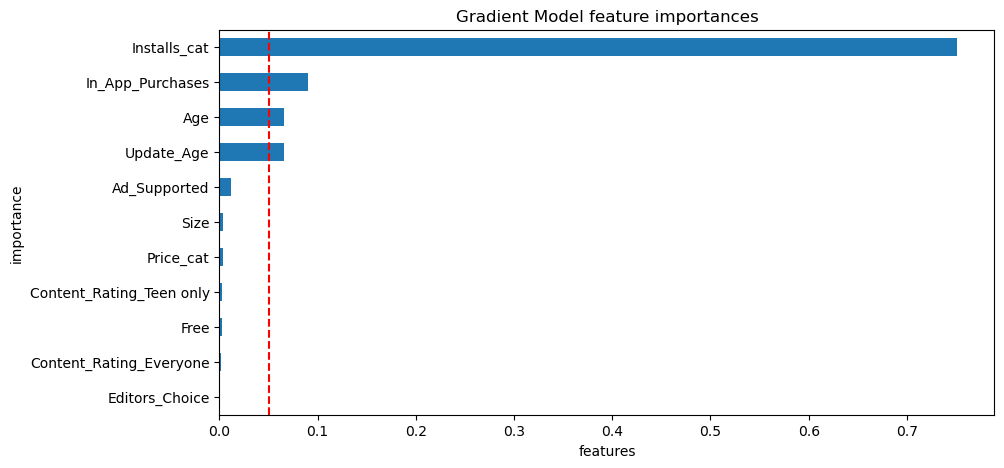

In [20]:
#Plot  feature importances

gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1, max_features=5, 
                                    max_depth = 5, random_state = 123)

c0_under = RandomUnderSampler(sampling_strategy={0:int(count[0]*0.6)},random_state=123)
c1_over = RandomOverSampler(sampling_strategy={1:int(count[1]*1.4)},random_state=123)

pipel = Pipeline([('under0',c0_under),
                  ('over1',c1_over),
                  ('model',gb_clf)])
#print(pipel.get_params().keys())

pipel.fit(X_train,y_train)

plt.subplots(figsize=(10, 5))
imps = pipel.steps[2][1].feature_importances_
gb_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=True)
print(gb_feat_imps)
gb_feat_imps.plot(kind='barh')
plt.xlabel('features')
plt.ylabel('importance')
plt.axvline(0.05,color='red', linestyle='--')
#plt.arrow(x=0, y=0, dx=W, dy=H, **arrow_style)
#plt.text(x=W/2+offsetX, y=H/2, s="U")
plt.title('Gradient Model feature importances');

## 4.4  MLPClassifier Model with Resampling

In [16]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(random_state = 123)

c0_under = RandomUnderSampler(sampling_strategy={0:int(count[0]*0.6)},random_state=123)
c1_over = RandomOverSampler(sampling_strategy={1:int(count[1]*1.4)},random_state=123)

pipel = Pipeline([('under0',c0_under),
                  ('over1',c1_over),
                  ('model',mlp_clf)])
#print(pipel.get_params().keys())

pipel.fit(X_train,y_train)
y_pred=pipel.predict(X_test)
pl = confusion_matrix(y_test,y_pred)

print("MLPClassifier Model with Resampling: \n{}".format(classification_report(y_test,y_pred)))

MLPClassifier Model with Resampling: 
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     12351
           1       0.55      0.50      0.52      1692

    accuracy                           0.89     14043
   macro avg       0.74      0.72      0.73     14043
weighted avg       0.89      0.89      0.89     14043

